# Анализ поведения пользователей мобильного приложения 

В нашем распоряжении данные стартапа, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи этого мобильного приложения. Для этого проведем А/А/В-тест. Узнаем, как изменилось поведение пользователей при изменении шрифта во всем приложении. Сначала сравним контрольные группы, т.е. проведем А/А-тест, далее при успешном проведении этого теста приступим к А/В-тесту.

**Цели исследования:**

- Изучить воронку продаж
- Провести анализ результатов A/A/B-эксперимента

**Ход исследования:** 

1. Обзор данных
2. Предобработка данных
3. Изучение и проверка данных
4. Изучение воронки событий
5. Изучение результатов А/А/В-эксперимента
6. Общий вывод

In [30]:
# Импортируем нужные нам библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import math as mth
from scipy import stats as st
import numpy as np
import plotly.express as px

## Обзор данных

In [31]:
# Считываем данные

data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [32]:
# Выводим общую информацию о датафрейме

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Промежуточный вывод по этапу обзора данных

В таблице с логами 244126 строк и 4 столбца: название события, уникальный id пользователя, дата и время события и группа эксперимента. Названия столбцов не соответствуют змеиному регистру, на этапе предобработки нужно будет изменить тип данных столбца со временем. 

## Предобработка данных

Для начала изменим названия столбцов

In [33]:
# Меняем названия столбцов

data.columns = ['event_name', 'user_id', 'event_timestamp', 'exp_id']
data.head(1)

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246


Теперь проверим данные на наличие явных и неявных дубликатов

In [34]:
print('Количество явных дупликатов:', data.duplicated().sum())

Количество явных дупликатов: 413


Обнаружено 413 полностью одинаковых строк, удалим их

In [35]:
# Удаляем дупликаты

data = data.drop_duplicates()
data.duplicated().sum()

0

Проверим столбец с событиями на неявные дупликаты

In [36]:
# Выводим уникальные значения столбца

data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Неявных дупликатов нет

Теперь исследуем датафрейм на наличие пропущенных значений

In [37]:
data.isna().sum()

event_name         0
user_id            0
event_timestamp    0
exp_id             0
dtype: int64

Пропусков нет

Вместо изменения типа данных в столбце со временем события, добавим два новых столбца с датой и временем - один будет с датой и временм, другой только с датой.

In [38]:
data['datetime'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['date'] = data['datetime'].dt.date
data.head()

,event_name,user_id,event_timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


### Промежуточный вывод по этапу предобработки данных

- **Пропуски:** пропущенных значений нет
- **Дупликаты:** было удалено 413 явных дупликатов, неявных обнаружено не было
- **Типы данных:** вместо изменения типа данных было добавлено 2 новых столбца

## Изучение и проверка данных

Проверим, сколько всего пользователей и событий в логе

In [39]:
print('Общее число пользователей:', data['user_id'].nunique(), '\n'
      'Общее количество событий:', data.shape[0])

Общее число пользователей: 7551 
Общее количество событий: 243713


In [40]:
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

В логе 7551 уникальных пользователей и 243713 событий, из которых 5 являются уникальными.

In [41]:
round(data.shape[0]/data['user_id'].nunique())

32

В среднем на пользователя приходится около 32 событий. Теперь нужно узнать, данными за какой период мы располагаем, а также определить минимальную и максимальную дату

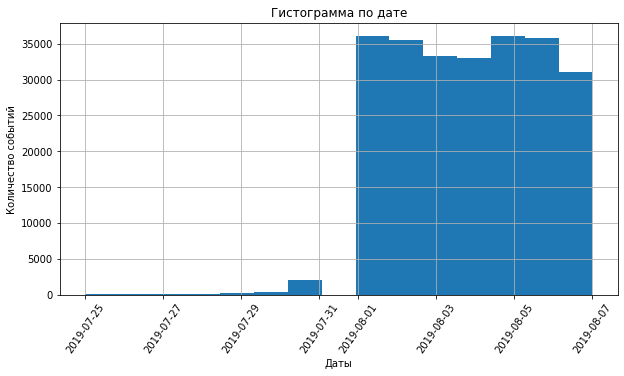

In [42]:
plt.figure(figsize=(10, 5))

data['date'].hist(bins=15)
plt.title('Гистограмма по дате')
plt.xlabel('Даты')
plt.ylabel('Количество событий')
plt.xticks(rotation=55);

По гистограмме видно, что в нашем распоряжении данные с 25 июля по 7 августа 2019 года, ровно 2 недели, но данные за июль - неполные, поэтому на самом деле мы располагаем данными только за август, очистим датафрейм от июльских событий.

In [43]:
data['date'] = data['date'].astype(str)
logs = data.query('date >= "2019-08-01"')
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   user_id          240887 non-null  int64         
 2   event_timestamp  240887 non-null  int64         
 3   exp_id           240887 non-null  int64         
 4   datetime         240887 non-null  datetime64[ns]
 5   date             240887 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 12.9+ MB


In [44]:
print('Всего пользователей потеряно:', data['user_id'].nunique() - logs['user_id'].nunique())

Всего пользователей потеряно: 17


In [45]:
print('Количество удаленных строк:', data.shape[0] - logs.shape[0])

Количество удаленных строк: 2826


In [46]:
logs.groupby('exp_id').agg({'user_id': 'nunique'}).reset_index()\
.rename(columns={'exp_id': 'Экспериментальная группа', 'user_id': 'Количество пользователей'})

,Экспериментальная группа,Количество пользователей
0,246,2484
1,247,2513
2,248,2537


После фильтрации было удалено всего лишь 17 пользователей и 2826 строк, также по таблцие выше видно, что пользователи равномерно распределены по экспериментальным группам

### Промежуточный вывод по этапу изучению и проверке данных

За 2 недели наблюдения было выявлено 7551 уникальных пользователей. В среднем на одного пользователя приходится 32 события. С помощью гистограммы был определен актуальный период исследования: первая неделя августа 2019 года. После фильтрации по дате было потеряно всего лишь 17 пользователей и удалено 2826 логов событий. Такие измененеия не повлияли на равномерное распределение пользователей по экспериментальным группам.

## Изучение воронки событий

Сначала посмотрим, как события распределены по количеству

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64


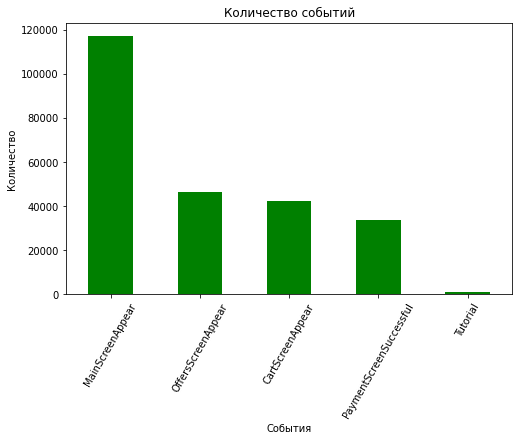

In [47]:
print(logs.groupby('event_name')['event_name'].count().sort_values(ascending=False))

(
logs.groupby('event_name')['event_name'].count().sort_values(ascending=False)
.plot(kind='bar', 
          title='Количество событий', 
          xlabel='События', 
          ylabel='Количество',
          rot=60,
          figsize=(8,5),
          color='g')
);

Самое популярное событие - появление основного экрана, за ним идут появления экранов предложений, корзины и упешной оплаты. Экран с обучением был посещен всего 1005 раз.

Теперь взглянем, как пользователи распределены по событиям:

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64


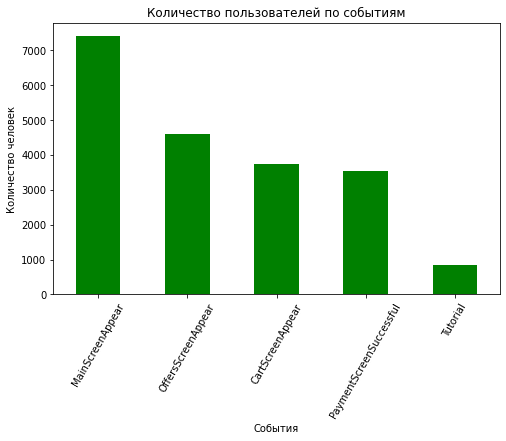

In [48]:
print(logs.groupby('event_name')['user_id'].nunique().sort_values(ascending=False))

(
logs.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
.plot(kind='bar', 
          title='Количество пользователей по событиям', 
          xlabel='События', 
          ylabel='Количество человек',
          rot=60,
          figsize=(8,5),
          color='g')
);

Картина примерно похожая, появление главного экрана также впереди остальных событий, но события корзина и оплата практически одинаковы по частоте, то есть почти все пользователи, зашедшие в корзину, оформляют покупку до конца. Обучением пользователи в большинстве случаев пренебрегают, оно и понятно, ведь управление в мобильном приложении интуитивно понятно для многих, и пользователи чаще всего пропускают туториал.

event_name
MainScreenAppear           98.47%
OffersScreenAppear         60.96%
CartScreenAppear           49.56%
PaymentScreenSuccessful    46.97%
Tutorial                   11.15%
Name: user_id, dtype: object

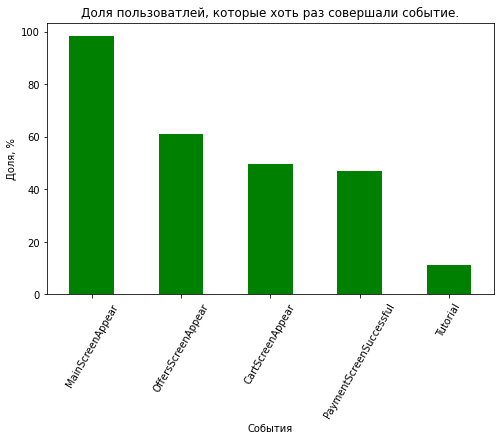

In [49]:
display((round(logs.groupby('event_name')['user_id'].nunique()/7534*100, 2).astype(str) + '%').sort_values(ascending=False))

(
    round(logs.groupby('event_name')['user_id'].nunique()/7534*100, 2).sort_values(ascending=False)
    .plot(kind='bar', 
          title='Доля пользоватлей, которые хоть раз совершали событие.', 
          xlabel='События', 
          ylabel='Доля, %',
          rot=60,
          figsize=(8,5),
          color='g')
);

Если рассматривать доли, то картина никак не поменялась в сравнении с выше описанным графиком, отсюда видно, что доля пользователей, дошедших от первого события до оплаты, равна ~47%, неплохо. Примерно 1.5% пользователей даже не увидели главный экран, возможно они прекратили пользоваться приложением еще на этапе обучения. Можно предположить, что события идут в таком порядке, который изображен в таблице, за исключением обучения, так как его можно просто пропустить или же вернуться позже, поэтому не будем учитывать это событие в исследовании воронки.

In [50]:
funnel = (
         logs.pivot_table(index='event_name', values='user_id', aggfunc='nunique')
         .sort_values(by='user_id', ascending=False).reset_index().rename(columns={'user_id': 'n_users'})
         )
funnel = funnel.query('event_name != "Tutorial"')
funnel

,event_name,n_users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [51]:
fun = dict(
    number=funnel['n_users'],
    stage=funnel['event_name'])
fig = px.funnel(fun, x='number', y='stage')
fig.show()

Мы визуализировали воронку, сразу же видно, что наибольшая доля пользователей теяктся на этапе "главный экран">>>"экран предложений", а доля успешно оплативших заказ почти совпадает с долей пользователей, которые зашли в корзину.

In [52]:
funnel.loc[0, 'funnel_ratio'] = '{:.2%}'.format(logs.query('event_name == "MainScreenAppear"')['user_id'].nunique()/\
                                logs.query('event_name == "MainScreenAppear"')['user_id'].nunique())
funnel.loc[1, 'funnel_ratio'] = '{:.2%}'.format(logs.query('event_name == "OffersScreenAppear"')['user_id'].nunique()/\
                                logs.query('event_name == "MainScreenAppear"')['user_id'].nunique())
funnel.loc[2, 'funnel_ratio'] = '{:.2%}'.format(logs.query('event_name == "CartScreenAppear"')['user_id'].nunique()/\
                                logs.query('event_name == "OffersScreenAppear"')['user_id'].nunique())
funnel.loc[3, 'funnel_ratio'] = '{:.2%}'.format(logs.query('event_name == "PaymentScreenSuccessful"')['user_id'].nunique()/\
                                logs.query('event_name == "CartScreenAppear"')['user_id'].nunique())
funnel

,event_name,n_users,funnel_ratio
0,MainScreenAppear,7419,100.00%
1,OffersScreenAppear,4593,61.91%
2,CartScreenAppear,3734,81.30%
3,PaymentScreenSuccessful,3539,94.78%


По таблице видно, что на шаге "главный экран">>>"экран предложений" теряется больше всего пользователей - 38%. И как было сказано ранее, почти все пользователи, зашедшие в корзину, оформляют покупку до конца - 95%. Доля пользователей, дошедших от первого события до оплаты, равна ~47%. Эти выводы подтверждаются ранее визуализированной воронкой.

### Промежуточный вывод по этапу изучения воронки событий

События идут в следующем порядке: появление главного экрана, появление экрана с предложениями, появление экрана с корзиной и появление экрана об успешной оплате. Наибольшее количество пользоватлей теряется на этапе "главный экран">>>"предложения" - 38%. Доля пользователей, дошедших от первого события до оплаты, равна ~47%. Событие "обучение" не было учтено, так как оно не принадлежит исследуемой воронке.

## Изучение результатов А/А/В-эксперимента

Посмотрим на количество пользователей в экспериментальных группах

In [53]:
logs.groupby('exp_id').agg({'user_id': 'nunique'})

,user_id
exp_id,
246,2484
247,2513
248,2537


Как и говорилось ранее, пользователи равномерно распределены по группам: вся выборка была поделена на три равные части по ~2500 человек.

Есть 2 контрольные группы для А/А-эксперимента, которые нужны для проверки корректности всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Для этого напишем функцию, которая будет проводить этот тест. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, сделаем поправку Бонферрони: для групп 246 и 247 n=4, в остальных случаях n=12, где n равно количеству проверяемых гипотез. При сравнении контрольных групп нас интересуют только совпадения по событиям, то есть по 4 событиям идет равенство, а при сравнении с 248 группой нас интересует любой результат: больше, меньше или равно.

In [54]:
def test(group1, group2, event_name, alpha, n):

    # критический уровень статистической значимости c поправкой Бонферрони
    alpha = alpha / n
 
    # число пользователей в группе 1 и группе 2:
    n_users = np.array([group1['user_id'].nunique(), 
                        group2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([group1[group1['event_name'] == event_name]['user_id'].nunique(), 
                        group2[group2['event_name'] == event_name]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    print('Событие:', event_name)
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Функция готова, можно приступать к проверке.

- **Нулевая гипотеза:** доли посетителей на одном и том же этапе воронки в двух разных группах одинаковы
- **Альтернативная гипотеза:** доли посетителей на одном и том же этапе воронки в двух разных группах разные

In [55]:
for event_name in funnel['event_name'].unique():
    test(logs.query('exp_id == 246'), logs.query('exp_id == 247'), event_name, 0.05, 4)
    print('\n')

Событие: MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие: OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие: CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие: PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




Две контрольные группы 246 и 247 прошли проверку, можно приступать к А/В-тесту

In [56]:
for event_name in funnel['event_name'].unique():
    test(logs.query('exp_id == 246'), logs.query('exp_id == 248'), event_name, 0.05, 12)
    print('\n')

Событие: MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие: OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие: CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие: PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




Между группами 246 и 248 нет статистически значимых различий.

In [57]:
for event_name in funnel['event_name'].unique():
    test(logs.query('exp_id == 247'), logs.query('exp_id == 248'), event_name, 0.05, 12)
    print('\n')

Событие: MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие: OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие: CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие: PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




Между группами 247 и 248 также нет различий.

In [58]:
for event_name in funnel['event_name'].unique():
    test(logs.query('exp_id != 248'), logs.query('exp_id == 248'), event_name, 0.05, 12)
    print('\n')

Событие: MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие: OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие: CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие: PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




Между объединенными группами 246 и 247 нет различий с группой 248.

### Промежуточный вывод по этапу изучения результатов А/А/В-эксперимента

Для проверки групп на наличие статистически значимых различий была создана функция test(), которая принимала на вход две выборки, событие, уровень статистической значимости и поправку Бонферрони. Две контрольные группы прошли А/А-тест, значит можно было приступить к А/А/В-тесту. Никаких различий между группами выявлено не было - изменение шрифта никак не повлияло на поведение пользователей.

## Общий вывод

В нашем распоряжении были данные стартапа, который продаёт продукты питания. Нужно было разобраться, как ведут себя пользователи этого мобильного приложения и узнать, как изменится поведение пользователй при изменении шрифта во всем приложении. Все цели исследования были достигнуты:

- Изучины воронки продаж
- Проведен анализ результатов A/A/B-эксперимента

На этапе предобработки данных было выявлено 413 явных дупликатов, пропущенных значений в исходном датафреййме не было обнаружено, вместо изменения типа данных были добавлены новые столбцы с датой и временм события.

За 2 недели наблюдения было выявлено 7551 уникальных пользователей. В среднем на одного пользователя приходится 32 события. С помощью гистограммы был определен актуальный период исследования: первая неделя августа 2019 года. После фильтрации по дате было потеряно всего лишь 17 пользователей и удалено 2826 логов событий. Такие измененеия не повлияли на равномерное распределение пользователей по экспериментальным группам.

События идут в следующем порядке: появление главного экрана, появление экрана с предложениями, появление экрана с корзиной и появление экрана об успешной оплате. Наибольшее количество пользоватлей теряется на этапе "главный экран">>>"предложения" - 38%. Доля пользователей, дошедших от первого события до оплаты, равна ~47%. Событие "обучение" не было учтено, так как оно не принадлежит исследуемой воронке.

Для проверки групп на наличие статистически значимых различий была создана функция test(), которая принимала на вход две выборки, событие, уровень статистической значимости и поправку Бонферрони. Две контрольные группы прошли А/А-тест, значит можно было приступить к А/А/В-тесту. Никаких различий между группами выявлено не было.

**Вывод: изменение шрифта никак не повлияло на поведение пользователей.**